## ***20BCE1952 - Simhadri Mohana Kushal***

# Novel Customer Segmentation on Credit Card Customer Details

## About the Dataset

The sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables

The following is the structure of the data set:

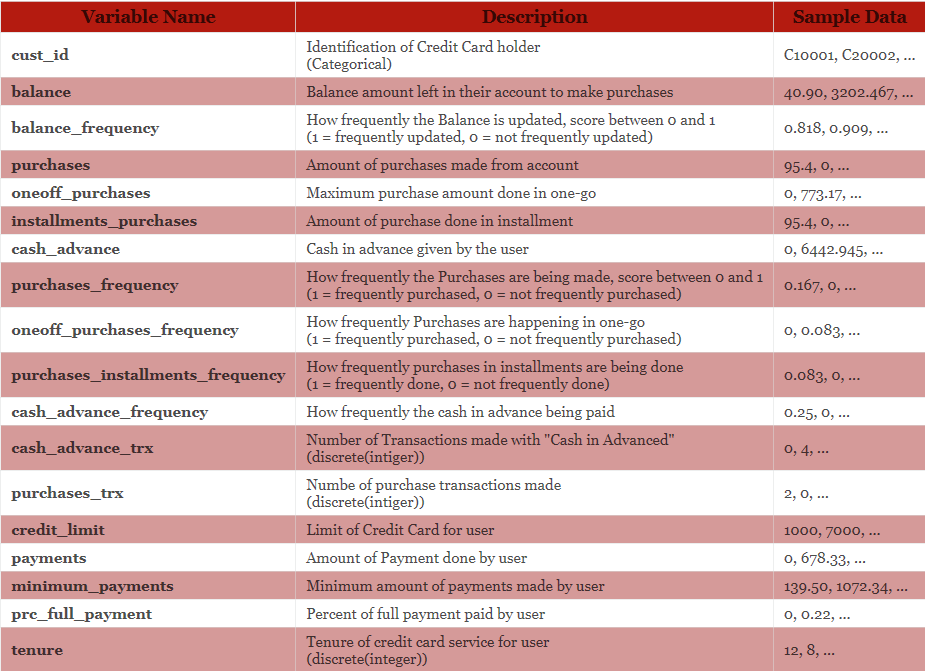

## Importing Librabies and Dataset

In [ ]:
# Import requirement libraries and tools for visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from termcolor import colored

# for solve problem of show plotly plots
# from plotly.offline import init_notebook_mode
# init_notebook_mode(connected=True)

# Optional
# for filter warnings
import warnings
warnings.filterwarnings('ignore')

# Import requirement libraries and tools for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, estimate_bandwidth, AffinityPropagation, Birch, DBSCAN, OPTICS, AgglomerativeClustering 
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from itertools import product
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator

In [ ]:
def custom_palette(custom_colors):
    """Show color palette that use in this notebook"""
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

 # for plot title
FONT = {'fontsize':30, 'fontstyle':'normal', 'fontfamily':'Georgia', 'backgroundcolor':'#B41B10', 'color':'#E4C09E'}

# Create List of Color Palletes
colors1 = ["#D1382F", "#392E37", "#F1F0F0", "#34C5B3", "#D79C4C", "#999EA2", "#D59A99", "#E4C09E"]
colors2 = ["#7D1F3F","#303336","#ECE3E2","#D24E49","#B41B10"]
dark_colors = ["#B41B10", "#D79C4C", "#8e18be", "#34C5B3", "#7D1F3F", "#a2c723", "#42575B"]
# Plot Color Palletes
for color in [colors1, colors2, dark_colors]:
    custom_palette(color)

In [ ]:
# Import customer dataset
df = pd.read_csv("Customer_Data.csv")
df

## Overview of Dataset

In [ ]:
# Overview of dataset
df.info()

According to the above results:
* The Dataset has 8950 rows (Customer) and 18 columns (features).
* It seems that the credit_limit and minimum_payments columns have missing values and should be checked further.
* Except for the cust_id column with object type, the rest of the columns have numeric values with type float64 or int64.

In [ ]:
# Show detaile data set
desc_cust = df.select_dtypes(include=['int64','float64']).describe().T
desc_cust_df = pd.DataFrame(index=desc_cust.index, columns=desc_cust.columns, data=desc_cust )

f,ax = plt.subplots(figsize=(12,12),dpi=100)

sns.heatmap(desc_cust_df, annot=True,cmap = "Reds", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 16})

ax.xaxis.set_ticks_position('top')
plt.tick_params(left=False, top=False)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.title("Descriptive Statistics", pad=30, x=0.31, y=1.02, fontdict=FONT)
plt.show()

In [ ]:
# Drop the cust_id columns because we do not neet it
df = df.drop('cust_id', axis=1)

## Cleaning Dataset

In [ ]:
def highlight_cells(val):
    """Highlight cells that is not zero"""
    f_color = '#D1382F' if val != 0 else ''  # Red
    bg_color = '#D59A99' if val != 0 else ''   # Pink
    w_font = 'bold'
    return 'background-color: {}; color: {}; font-weight: {}'.format(bg_color, f_color, w_font)

# Check missing values
is_nan = df.isna().sum().to_frame(name='Number_of_NaN')
is_nan.insert(1,'Percent(%)', [round(x/df.shape[0]*100,2) for x in is_nan.Number_of_NaN])
is_nan.style.applymap(highlight_cells)

In [ ]:
# Overview nan value in credit_limit column
df[df.credit_limit.isna()]

Since only one datapoint has a missing value in credit_limit, we do not waste time and delete this row.

In [ ]:
# Drop row with nan value in credit_limit
df = df.drop(df[df.credit_limit.isna()].index, axis=0)

In [ ]:
# Show detaile of datapoint with missing values
desc_cust = df[df.minimum_payments.isna()].describe().T

desc_cust_df = pd.DataFrame(index=desc_cust.index, columns=desc_cust.columns, data=desc_cust )

f,ax = plt.subplots(figsize=(15,15),dpi=100)

sns.heatmap(desc_cust_df, annot=True,cmap = "Reds", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 16})

ax.xaxis.set_ticks_position('top')
plt.tick_params(left=False, top=False)
plt.xticks(size = 18)
plt.yticks(size = 18)

plt.title("Descriptive Statistics of Missing Values", pad=30, x=0.31, y=1.02, fontdict=FONT)
plt.show()

In [ ]:
# Overview correlation between features
plt.figure(figsize=(13,8), dpi=100)
sns.heatmap(round(df.corr(),2), annot=True, cmap='gist_heat_r')
plt.title("Correlation Between Features", pad=30, fontdict=FONT)
plt.show()

Since there is not much linear correlation between minimum_payments and other features, it is not possible to get the missing values from other features with the help of linear regression, so we use KNNimputer to fill the missing values.

In [ ]:
# Fill the remaining missing values with KNNimputer()
# Define imputer
imputer = KNNImputer()
# Fit on the dataset
imputer.fit(df)
# Transform the dataset
df1 = pd.DataFrame(imputer.transform(df),columns=df.columns)

# Print result
print(colored(f'Missing (before): {df.isna().sum().sum()}', 'red'))
print(colored(f'Missing (after): {df1.isna().sum().sum()}', 'green'))   

In [ ]:
# Check duplicated data
print(colored(f"Number of dupilcated data: {df1.duplicated().sum()}", 'red'), )

In [ ]:
# Draw pair plot for check noise and
pplot = sns.pairplot(df1, palette="#B41B10")
pplot.fig.suptitle("Pariplot of Features", y=1.02, **FONT)
pplot.tight_layout()
plt.show()

In [ ]:
# Draw boxplot for check outliers
fig ,ax = plt.subplots(8,2,figsize=(20,40))
for i, col in enumerate(set(df1.columns)-set(['tenure'])):
    sns.boxplot(data=df1, x=col, palette="Reds_r", saturation=1, linewidth = 2, ax=ax[i//2, i%2])
plt.suptitle("Check Outlier with boxplot", y=1, **FONT)
plt.tight_layout(pad=3.0)
plt.show()

As you can see, the number of outliers is high, but it is normal for this type of dataset. ***outliers are innocent until proven guilty***. With that being said, they should not be removed unless there is a good reason for that. According to pairplot, noisy data does not appear to exist. Therefore, we do not delete any data.

## Exploratory Data Analysis (EDA)

In clustering problems where the number of features and datasets are large, the basic EDA before clustering and finding the number of clusters according to them is a bit difficult, but here we try to make guesses about the number of clusters. And after modeling, we do EDA again on the built model

### Univariate Analysis

In [ ]:
# Check distribution of features
fig, ax = plt.subplots(17, 1, figsize=(10,50))
for i, col in enumerate(df1):
    sns.histplot(df1[col], kde=True, ax=ax[i], color='red')
    
fig.suptitle('Distribution of Columns',y=1.002, **FONT)
fig.tight_layout()
plt.show()

In [ ]:
# Check distribution of some features in more detail
cols = ['purchases', 'oneoff_purchases', 'installments_purchases', 'cash_advance', 'minimum_payments']
fig, ax = plt.subplots(5, 1, figsize=(10,25))
for i, col in enumerate(cols):
    sns.histplot(df1[df1 < 4000][col], kde=True, ax=ax[i], color='red')
    
fig.suptitle('Distribution of Some Columns (in more detail)',y=1.002, **FONT)
fig.tight_layout(pad=3)
plt.show()

### Bivariate Analysis

In [ ]:
# Draw pair plot for EDA
pplot = sns.pairplot(df1, palette="#B41B10", markers='.')
pplot.fig.suptitle("Pariplot of Features", y=1.02, **FONT)
pplot.tight_layout()
plt.show()

Considering that the number of data is large and the features are relatively large, it is difficult and time-consuming to check them, so we check only a few plots from drawn pairplot that help us to clustering:

From the drawn pairplot, the histogram of ***purchases_frequency*** and ***purchases_installments_frequency*** features gives us relatively good information:

In [ ]:
# Check distribution of purchases_frequency and purchases_installment_frequency in more detail
fig, ax = plt.subplots(1,2,figsize=(15,5), dpi=100)
for i,col in enumerate(['purchases_frequency', 'purchases_installments_frequency']):
    sns.histplot(df1[col], kde=True, color='red', ax=ax[i])

fig.suptitle('Distribution of Some Columns (in more detail)', **FONT)
fig.tight_layout()
plt.show()

The ***purchases_frequency*** distribution has two peaks, one at zero (left side of the plot) and one at one (right side of the plot). Therefore, based on this feature, the data can be divided into two clusters:
* customers with low purchases_frequency
* customers with high purchases_frequency

The ***purchases_installments_frequency*** distribution also has two peaks, one at zero (left side of the plot) and one at one (right side of the plot). Therefore, based on this feature, the data can be divided into two clusters:
* customers with low purchases_installments_frequency
* customers with high purchases_installments_frequency

### Multivariate Analysis

In [ ]:
# Correlation between features
plt.figure(figsize=(13,8), dpi=500)
sns.heatmap(round(df.corr(),2), annot=True, cmap='gist_heat_r')
plt.title("Correlation Between Features", pad=30, fontdict=FONT)
plt.tight_layout()
plt.show()

As can be seen, each customer's ***balance*** is more correlated with ***cash_advance*** and ***credit_limit***. Also, the ***purchases*** of each customer have the highest correlation with o***neoff_purchases***, ***purchases_trx***, ***installments_purchases*** and ***payments***.

Now we go to the clustering customer

## Clustering Models

Before clustering, we standardize the data. Then, using existing algorithms, we cluster the dataset, evaluate and check the results, and choose the best clustering model.

In [ ]:
# Standardize dataset
scaler = StandardScaler().fit(df1)
df_trans = scaler.transform(df1)
df2 = pd.DataFrame(df_trans, columns = df1.columns)
df2

Now let's implement the first clustering algorithm:

### Kmeans

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified.

First, we determine the optimal k (number of clusters) using the elbow technique, and then we implement the kmeans algorithm for the optimal k.

In [ ]:
# Kmeans algorithm settings
kmeans_set = {"init":"random", "n_init":10, "max_iter":300, "random_state":42}
# Find inertia for k cluster
inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)
    kmeans.fit(df2)
    inertias.append(kmeans.inertia_)

In [ ]:
def elbow_optimizer(inertias,name):
    """ Find optimom k for clustering algorithm
        inertias (list): list that has inertia for each selected k
        name (string): name of clustering algorithm
    """

    kl = KneeLocator(range(1,11), inertias, curve='convex', direction="decreasing")
    plt.style.use("fivethirtyeight")
    sns.lineplot(x=range(1,11), y=inertias, color=dark_colors[0])
    plt.xticks(range(1,11))
    plt.xlabel("Number of Clusters", labelpad=20)
    plt.ylabel("Inertia", labelpad=20)
    plt.title(f"Elbow Method for {name}", y=1.09, fontdict=FONT)
    plt.axvline(x=kl.elbow, color=dark_colors[-1], label='axvline-fullheight', ls='--')
    plt.show()

In [ ]:
# Implement elbow_optimizer function for KMeans
elbow_optimizer(inertias, 'Kmeans')

Based on the elbow method, the optimal number of clusters for kmeans algorithm is equal to 4. Now, we evaluate this result with the help of internal validation techniques. Here we use silhouette_score and calinski_harabasz_score for internal validation:

In [ ]:
# Calculate silhouette_score and calinski_harabasz_score
silhouette_coef = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)
    kmeans.fit(df2)
    score = silhouette_score(df2, kmeans.labels_)
    silhouette_coef.append(score)

calinski_harabasz_coef = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)
    kmeans.fit(df2)
    score = calinski_harabasz_score(df2, kmeans.labels_)
    calinski_harabasz_coef.append(score)

In [ ]:
def plot_evaluation(sh_score, ch_score, name, x=range(2,11)):
    """
    for draw evaluation plot include silhouette_score and calinski_harabasz_score.
        sh_score(list): include silhouette_score of models
        ch_score(list): include calinski_harabasz_score of models
        name(string): name of clustering algorithm
        x(list): has range of number for x axis
    """
    
    fig, ax = plt.subplots(1,2,figsize=(15,7), dpi=100)
    ax[0].plot(x, sh_score, color=dark_colors[0], marker='o', ms=9, mfc=dark_colors[-1])
    ax[1].plot(x, ch_score, color=dark_colors[0], marker='o', ms=9, mfc=dark_colors[-1])
    ax[0].set_xlabel("Number of Clusters", labelpad=20)
    ax[0].set_ylabel("Silhouette Coefficient", labelpad=20)
    ax[1].set_xlabel("Number of Clusters", labelpad=20)
    ax[1].set_ylabel("calinski Harabasz Coefficient", labelpad=20)
    plt.suptitle(f'Evaluate {name} Clustering',y=0.9, **FONT)
    plt.tight_layout(pad=3)
    plt.show()

In [ ]:
# Draw plots of silhouette_score and calinski_harabasz_score for kmeans models
# To check the correctness of the result obtained from the elbow method
plot_evaluation(silhouette_coef, calinski_harabasz_coef, 'Kmeans')

According to the results obtained from the above graphs, both graphs confirm the number of 3 clusters as the optimal k, but Calinski's graph rejects cluster 4 in a way.

Therefore, we consider the optimal k to be 3 and again implement kmeans for ***n_clusters=3***.

In [ ]:
# Create dict to store results of clustering algorithms for comparision
best_model = pd.DataFrame({'Model':[], 'Sil_score':[], 'CH_score':[], 'setting':[]})

In [ ]:
# Implement kmeans for n_clusters=3
kmeans = KMeans(n_clusters=3, **kmeans_set).fit(df2)
# Store result of kmeans
pred = kmeans.labels_
# Store the coordinates of centroids
centroids = kmeans.cluster_centers_
centroids = pd.DataFrame(data=centroids, columns = [df2.columns])
centroids.T

In [ ]:
# Store resluts of kmeans
best_model.loc[len(best_model.index)] = [
    f"Kmeans",
    silhouette_score(df2, pred),
    calinski_harabasz_score(df2, pred),
    {"n_clusters":3, **kmeans_set}]

In [ ]:
# Transmition slaced centroids to real
real_centroids = scaler.inverse_transform(centroids)
real_centroids = pd.DataFrame(data=real_centroids, columns = [df2.columns])
real_centroids.T

In [ ]:
# Adding the clusters column to the main dataframe (df2) and store in new dataframe
df_result_kmeans = pd.concat([df1, pd.DataFrame(pred, columns=['cluster'])], axis = 1)
df_result_kmeans

In [ ]:
# Overview of resluts
def check_result(data):
    """
    Check results obtained from each algorithm and number of clusters
    data(Dataframe): orgindal dataset + cluster column obtained from algorithm
    """

    fig, axes = plt.subplots(1,2,figsize=(10,4))
    # Count of cluster (countplot)
    sns.countplot(data=data, x='cluster', ax=axes[0], palette=dark_colors[0:int(data.cluster.nunique())], saturation=1, edgecolor = "#1c1c1c", linewidth = 2)
    for container in axes[0].containers:
        axes[0].bar_label(container, label_type="center", padding=5, size=12, color="black", rotation=0,
        bbox={"boxstyle": "round", "pad": 0.4, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 2, "alpha": 1})
    # Draw pie plot
    slices = data['cluster'].value_counts().sort_index().values
    activities = [var for var in data['cluster'].value_counts().sort_index().index]
    wedges, texts, autotexts = axes[1].pie(
        slices,
        labels=activities,
        shadow=True,
        autopct='%1.1f%%',
        textprops=dict(size=16, color="black"),
        pctdistance = 0.6,
        radius=1, 
        colors = dark_colors[0:int(data.cluster.nunique())], 
        wedgeprops=dict(edgecolor = "black", linewidth = 2),)

    plt.legend(
        wedges, 
        data.cluster.value_counts().sort_index().index, 
        title="Clusters",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        edgecolor = "black")


    plt.suptitle(f'Count of Each Cluster', y=1.09, **FONT)
    plt.show()

In [ ]:
# Implement check result function for Kmeans
check_result(df_result_kmeans)

Next, we implement other clustering algorithms and we check their obtained results with this result and finally choose the best algorithm according to silhouette and clainski evaluation criteria and check its result carefully.

### Mini Batch Kmeans

The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function.

MiniBatchKMeans converges faster than KMeans, but the quality of the results is reduced. In practice this difference in quality can be quite small.

In [ ]:
# Find inertia for k cluster
inertias = []
for k in range(1,11):
    mbkmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    mbkmeans.fit(df2)
    inertias.append(mbkmeans.inertia_)

In [ ]:
# Implement elbow_optimizer function for Mini Batch kmeans
elbow_optimizer(inertias, 'Mini Batch Kmeans')

In [ ]:
# Calculate silhouette_score and calinski_harabasz_score
silhouette_coef = []
for k in range(2,11):
    mbkmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    mbkmeans.fit(df2)
    score = silhouette_score(df2, mbkmeans.labels_)
    silhouette_coef.append(score)

calinski_harabasz_coef = []
for k in range(2,11):
    mbkmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    mbkmeans.fit(df2)
    score = calinski_harabasz_score(df2, mbkmeans.labels_)
    calinski_harabasz_coef.append(score)

Based on the elbow method, the optimal number of clusters for Mini Batch Kmeans algorithm is equal to 8. Now, we evaluate this result with the help of internal validation techniques. Here we use silhouette_score and calinski_harabasz_score for internal validation:

In [ ]:
# Draw plots of silhouette_score and calinski_harabasz_score for mini batch kmeans models
# To check the correctness of the result obtained from the elbow method
plot_evaluation(silhouette_coef, calinski_harabasz_coef, 'Mini Batch Kmeans')

The results obtained above are different from those obtained in the elbow method. Also, the graphs above show different results, which makes it difficult to decide on the optimal k. Considering that k=3 is the most optimal state according to Calinski and the difference between k=3 and k=10 does not make much difference in silhouette evaluation, We consider k=3 as the most optimal value.

In [ ]:
# Implement MiniBatchKmeans algorithm
mbkmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(df2)
# Store result of mini batch kmeans
pred = mbkmeans.labels_
# Store the coordinates of centroids
centroids = mbkmeans.cluster_centers_
centroids = pd.DataFrame(data=centroids, columns = [df2.columns])
centroids.T

In [ ]:
# Store results obtained from MiniBatchKmeans
best_model.loc[len(best_model.index)] = [
    f"Mini Batch Kmeans",
    silhouette_score(df2, pred),
    calinski_harabasz_score(df2, pred),
    {"n_clusters":3, "random_state":42}]

In [ ]:
# Transmition slaced centroids to real
real_centroids = scaler.inverse_transform(centroids)
real_centroids = pd.DataFrame(data=real_centroids, columns = [df2.columns])
real_centroids.T

In [ ]:
# Adding the clusters column to the main dataframe (df2) and store in new dataframe
df_result_mbkmeans = pd.concat([df1, pd.DataFrame(pred, columns=['cluster'])], axis = 1)
df_result_mbkmeans

In [ ]:
# Implement check_result function for MiniBatchKmeans
check_result(df_result_mbkmeans)

### Mean Shift

Mean shift is an unsupervised learning and a centroid based algorithm that is mostly used for clustering. It is widely used in real-world data analysis (e.g., image segmentation)because it’s non-parametric and doesn’t require any predefined shape of the clusters in the feature space.

Simply speaking, mean shift is equal to shifting to the mean in an iterative way. In the algorithm, every data point is shifting to the regional mean step by step and the location of the final destination of each point represents the cluster it belongs to.

Since mean shift clustering only has one parameter, the bandwidth, it needs super caution when choosing a appropriate value for it. The algorithm automatically sets the number of clusters, instead of relying on a parameter bandwidth, which dictates the size of the region to search through. This parameter can be set manually, but can be estimated using the provided estimate_bandwidth function, which is called if the bandwidth is not set.

The larger the local region is, the closer the local mean point is to the global one.


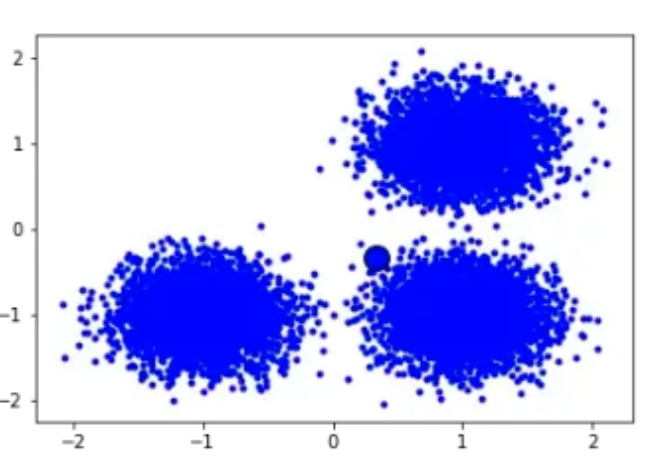


If we have a super small bandwidth, there will be a lot more non-sense clusters because we restricted the mean value calculation to a much smaller local area.


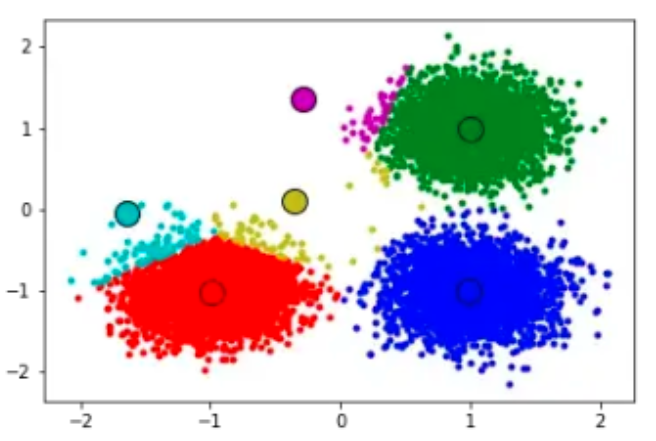


So, it’s better to have an idea about the bandwidth when doing the modeling.

In [ ]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(df2, n_samples=10, n_jobs=-1)
bandwidth

3.034622165900537

In [ ]:
# Implement mean shift with the bandwidth obtained from estimate_bandwidth
m_shift = MeanShift(bandwidth=bandwidth)
m_shift.fit(df2)
# Store result of mean shift
pred = m_shift.labels_
# Number of cluster
np.unique(pred)
# Evaluate results of mean shift by silhouette and calinski coefficient
sh_score = silhouette_score(df2, pred)
ch_score = calinski_harabasz_score(df2, pred)
# Print results
print(colored(f"Number of cluster: {np.unique(pred)}",'red'))
print(colored(f"Silhouette Coefficient: {sh_score}", 'red'))
print(colored(f"Calinski Harabasz Coefficient: {ch_score}", 'red'))

The number of predicted clusters is too large and does not suit us, and silhouette and calinski evaluations also do not show satisfactory results. So we select the bandwidth manually:

In [ ]:
# Find optimom bandwidth for implement mean shift by using silhouette and calinski coefficient
silhouette_coef = []
for k in range(10,16,2):
    m_shift = MeanShift(bandwidth=k)
    m_shift.fit(df2)
    score = silhouette_score(df2, m_shift.labels_)
    silhouette_coef.append(score)

calinski_harabasz_coef = []
for k in range(10,16,2):
    m_shift = MeanShift(bandwidth=k)
    m_shift.fit(df2)
    score = calinski_harabasz_score(df2, m_shift.labels_)
    calinski_harabasz_coef.append(score)

In [ ]:
# Draw plots of silhouette_score and calinski_harabasz_score for MeanShift models
plot_evaluation(silhouette_coef, calinski_harabasz_coef, 'Mean Shift', x=range(10,16,2))

According to the results obtained above, the best value for bandwidth is 12. Therefore, we implement mean shift once again, this time with bandwidth=12.

In [ ]:
# Implement mean shift with the bandwidth=12
m_shift = MeanShift(bandwidth=12)
m_shift.fit(df2)
# Store result of mean shift
pred = m_shift.labels_
# Number of cluster
np.unique(pred)
# Print results
print(colored(f"Number of cluster: {np.unique(pred)}",'red'))

Number of cluster: [0 1 2 3 4]


In [ ]:
# Store results obtained from Meanshift
best_model.loc[len(best_model.index)] = [
    f"Mean Shift",
    silhouette_score(df2, pred),
    calinski_harabasz_score(df2, pred),
    {"bandwidth":12}]

In [ ]:
# Store the coordinates of centroids
centroids = m_shift.cluster_centers_
centroids = pd.DataFrame(data=centroids, columns = [df2.columns])
centroids.T

In [ ]:
# Transmition slaced centroids to real
centroids = scaler.inverse_transform(centroids)
centroids = pd.DataFrame(data = centroids, columns = [df2.columns])
centroids

In [ ]:
# Adding cluster column to dataframe
df_result_mshift = pd.concat([df1, pd.DataFrame({'cluster': pred})], axis = 1)
df_result_mshift

In [ ]:
# Implement check_reuslts function for MeanShift model
check_result(df_result_mshift)

### Hierarchical clustering

Hierarchical clustering is one of the popular and easy to understand clustering technique. A Hierarchical clustering method works via grouping data into a tree of clusters. This clustering technique is divided into two types:
* Agglomerative
* Divisive

**Agglomerativ**e: Initially consider every data point as an individual Cluster and at every step, merge the nearest pairs of the cluster. (It is a bottom-up method). At first, every dataset is considered as an individual entity or cluster. At every iteration, the clusters merge with different clusters until one cluster is formed.

In [ ]:
# Draw dondrogram for Agglomerative clustering
def dendoOptimizer(data):
    """Plots a Dendogram Plot on the data provided"""
    sch.dendrogram(sch.linkage(data, method='ward'))
    plt.title('Dendrogram')
    plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    plt.show()

In [ ]:
# Implement dendoOptimizer
dendoOptimizer(df2)

# Find optimom bandwidth for implement agglomerative clustering by using silhouette and calinski coefficient

In [ ]:
silhouette_coef = []
for k in range(2,15):
    agg = AgglomerativeClustering(n_clusters=k)
    agg.fit(df2)
    score = silhouette_score(df2, agg.fit_predict(df2))
    silhouette_coef.append(score)

calinski_harabasz_coef = []
for k in range(2,15):
    agg = AgglomerativeClustering(n_clusters=k)
    agg.fit(df2)
    score = calinski_harabasz_score(df2, agg.fit_predict(df2))
    calinski_harabasz_coef.append(score)

In [ ]:
# Draw plots of silhouette_score and calinski_harabasz_score for AgglomerativeClustering models
plot_evaluation(silhouette_coef, calinski_harabasz_coef, 'Agglomerative', x=range(2,15))

According to the diagrams above, n_clusters=2 is appropriate. Therefore, we implement the Agglomerative algorithm with **n_clusters=2**:

In [ ]:
# Implement AgglomerativeClustering by n_clusters=2
agg = AgglomerativeClustering(n_clusters=2)
agg.fit(df2)
# Store result of Agglomerative
pred = agg.labels_
# Evaluate results of mean shift by silhouette and calinski coefficient
sh_score = silhouette_score(df2, pred)
ch_score = calinski_harabasz_score(df2, pred)
# Print results
print(colored(f"Silhouette Coefficient: {sh_score:.2f}", 'red'))
print(colored(f"Calinski Harabasz Coefficient: {ch_score:.2f}", 'red'))
# Adding the clusters column to the main dataframe (df2) and store in new dataframe
df_result_agg = pd.concat([df1, pd.DataFrame(pred, columns=['cluster'])], axis = 1)
df_result_agg

In [ ]:
# Store results obtained from AgglomerativeClustering
best_model.loc[len(best_model.index)] = [
    f"Agglomerative",
    silhouette_score(df2, pred),
    calinski_harabasz_score(df2, pred),
    {"n_clusters":2}]

In [ ]:
# Implement check_result function for AgglomerativeClustering model
check_result(df_result_agg)

## Comparision Models

Now it is time to show and compare the results obtained in the previous section in the form of a table and choose the best models.

In [ ]:
best_model

In [ ]:
# Show results obtained from different models in plot
fig, ax = plt.subplots(1,2,figsize=(15,7), dpi=100)
ax[0].plot(best_model.Model, best_model.Sil_score, marker='o', c=dark_colors[0], ms=9, mfc=dark_colors[-1])
ax[1].plot(best_model.Model, best_model.CH_score, marker='o', c=dark_colors[0], ms=9, mfc=dark_colors[-1])
ax[0].set_xlabel("Models", labelpad=20)
ax[0].set_ylabel("Silhouette Score", labelpad=20)
ax[1].set_xlabel("Models", labelpad=20)
ax[1].set_ylabel("Calinski-Harabasz Score", labelpad=20)
ax[0].tick_params(labelrotation=90) 
ax[1].tick_params(labelrotation=90) 
plt.suptitle(f'Comparision Models', **FONT)
plt.show()

As can be seen, according to the Silhouette criterion, Mean shift is the best model, and according to Calinski-Harabazs criterion, Kmeans is the best model.Therefore, we review and analyze all three mentioned models as proposed models.

## Clustering Analysis

In this section, we analyze and examine more closely the final 2 models of ***Kmeans*** and ***Mean Shift***

### Kmeans Clustering

In [ ]:
# Implement KMeans
#kmeans = KMeans(**models.setting[0])
kmeans.fit(df2)
pred_kmeans = kmeans.labels_
# Store the coordinates of centroids
centroids = kmeans.cluster_centers_
centroids = pd.DataFrame(data=centroids, columns=df2.columns)
# transmition slaced centroids to real
real_centroids = scaler.inverse_transform(centroids)
real_centroids = pd.DataFrame(data=real_centroids, columns=df2.columns)
# Adding the clusters column to the main dataframe (df2) and store in new dataframe
kmeans_result_df = pd.concat([df1, pd.DataFrame(pred_kmeans, columns=['cluster'])], axis = 1)
kmeans_result_df

In [ ]:
# Centroids in kmeans model
centroids

In [ ]:
# Implement check_result function for kmeans model again
check_result(kmeans_result_df)

As can be seen in Kmeans clustering with three clusters, the highest frequency belongs to cluster 1 with 68.2% of the data.

In [ ]:
# Separate and store each cluster
cluster0_df = kmeans_result_df[kmeans_result_df.cluster == 0]
cluster1_df = kmeans_result_df[kmeans_result_df.cluster == 1]
cluster2_df = kmeans_result_df[kmeans_result_df.cluster == 2]

In [ ]:
# Check distribution of each cluster
def check_hist(df, name, colors=dark_colors):
    """Check histogram of features in each cluster
        df(Dataframe): orginal dataset + cluster column obtained from model
        name(string): name of model (or algorithm)
        colors(list): list of colors using for palette in plot
    """
    
    plt.figure(figsize=(15, 60), dpi=200)
    for i, col in enumerate(df.iloc[:,:-1], 0):
        for j, clus in enumerate(zip(df.cluster.value_counts().sort_index().index, colors[0:int(df.cluster.nunique())]),1):
            plt.subplot(17,int(df.cluster.nunique()),j+i*int(df.cluster.nunique()))
            sns.histplot(df[df.cluster == clus[0]][col], color=clus[1], label=f'cluster {clus[0]}', bins=20)
            plt.ylabel("Counts", labelpad=10)
            plt.xlabel(col, labelpad=10)
            plt.legend()
    plt.suptitle(f"Distribution of Features in {name})",y=1, **FONT)
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
# Implement check_hist fucntion for Kmeans model
check_hist(kmeans_result_df, 'KMeans')

In [1]:
# Check KDE of clusters
def check_kde(df, name):
    """Check KDE of features for each cluster
        df(Dataframe): orginal dataset + cluster column obtained from model
        name(string): name of model (or algorithm)
    """
    
    plt.figure(figsize=(15, 25), dpi=200)
    for i, col in enumerate(df.iloc[:,:-1], 1):
        plt.subplot(6,3,i)
        sns.kdeplot(df[col], hue=df.cluster, shade=True, palette=dark_colors[0:int(df.cluster.nunique())])
        plt.ylabel("Density", labelpad=10)
        plt.xlabel(col, labelpad=10)
    plt.suptitle(f"Distribution of Each Cluster ({name})", **FONT)
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
# Implement check_kde for Kmeans model
check_kde(kmeans_result_df, 'KMeans')

In [ ]:
# Check pair plot for results of kmeans model
sns.pairplot(kmeans_result_df, hue='cluster', palette=dark_colors[0:3])
plt.show()

In [ ]:
# Check scatterplot of features based on cluster columns
cols1 = ['balance','balance_frequency','cash_advance','cash_advance_frequency','cash_advance_trx','credit_limit','installments_purchases','minimum_payments','oneoff_purchases','oneoff_purchases_frequency','payments','prc_full_payment','purchases_frequency','purchases_installments_frequency','purchases_trx','tenure']

def check_scatter(df, name):
    """Check Scatter plot of some features
        df(Dataframe): orginal dataset + cluster column obtained from model
        name(string): name of model (or algorithm)
    """
    
    plt.figure(figsize=(20, 20), dpi=200)
    for i, col in enumerate(cols1, 1):
        plt.subplot(4,4,i)
        sns.scatterplot(data=df, x=col, y='purchases', hue='cluster', palette=dark_colors[0:int(df.cluster.nunique())])
        sns.scatterplot(data=real_centroids, x=col, y='purchases', color='black', s=90)
        plt.ylabel("purchases", labelpad=10)
        plt.xlabel(col, labelpad=10)
    plt.suptitle(f"Scatterplot of Features in {name} Clustering", **FONT)
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
# Check correlation between features
plt.figure(figsize=(15,10), dpi=400)
sns.heatmap(round(kmeans_result_df.corr(),1),cmap='gist_heat_r', annot=True)
plt.title("Correlation Between Features", pad=30, fontdict=FONT)
plt.show()

In [ ]:
# Implement check_scatter fucntion for kmeans model
check_scatter(kmeans_result_df, 'Kmeans')

In [ ]:
# Check KDE of clusters
cols2 = ['balance','balance_frequency','cash_advance','cash_advance_frequency','cash_advance_trx','credit_limit','installments_purchases','minimum_payments','oneoff_purchases','oneoff_purchases_frequency','payments','prc_full_payment','purchases','purchases_installments_frequency','purchases_trx','tenure']

def check_kde_2(df, name):
    """Checking kde of each feature in clusters two by two
        df(Dataframe): orginal dataset + cluster column obtained from model
        name(string): name of model (or algorithm)
    """
    
    plt.figure(figsize=(20, 20), dpi=200)
    for i, col in enumerate(cols2, 1):
        plt.subplot(4,4,i)
        sns.kdeplot(df.purchases_frequency, df[col], hue=df.cluster, shade=True, fill=True, alpha=0.5, palette=dark_colors[0:int(df.cluster.nunique())])
        plt.ylabel("purchases_frequency", labelpad=10)
        plt.xlabel(col, labelpad=10)
    plt.suptitle(f"KDE of Features ({name})", **FONT)
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
# Implement check_kde_2 function for kmeans model
check_kde_2(kmeans_result_df, 'KMeans')

In [ ]:
# Check 3d scatterplot of features based on cluster columns
cols3 = ['balance','balance_frequency','cash_advance','cash_advance_frequency','cash_advance_trx','credit_limit','installments_purchases','minimum_payments','oneoff_purchases','oneoff_purchases_frequency','prc_full_payment','purchases','purchases_installments_frequency','purchases_trx','tenure']

def check_3d_scatter(df, name, color_map = {0:dark_colors[0], 1:dark_colors[1], 2:dark_colors[2], 3:dark_colors[3], 3:dark_colors[3]}):
    for i, col in enumerate(cols3, 1):
        fig = px.scatter_3d(
            data_frame= df,
            x='purchases_frequency',
            y='payments',
            z=col,
            color=df.cluster.astype('category'),
            color_discrete_map=color_map,
            opacity=0.6,
            height=500,
            title=f'3D visualization of {name} clustring')

        fig.update_traces(marker_size = 5)
        pio.show(fig)

In [ ]:
check_3d_scatter(kmeans_result_df, "Kmeans")

The following results can be obtained from the set of graphs drawn above and their analysis and review:
* Customers belonging to two clusters 1 and cluster 2 have a **low balance**, but customers belonging to cluster 0 have a **higher balance** than the other two clusters.
* Customers belonging to cluster 0 have **high purchases_frequency**, **high oneoff_purchases_frequency** and **high purchases_installment_frequency**, and customers belonging to cluster 2 have **low purchases_frequency**, ***low oneoff_purchases_frequency***, and **low purchases_installment_frequency**.
* Customers belonging to cluster 1 often have a **lower credit_limit** than customers in other clusters.
* Customers belonging to cluster 2 often have **higher cash_advance_frequency** than customers in other clusters.

Therefore, according to the results obtained from the KMeans algorithm, clusters 0 to 2 can be described as follows:
* ***Cluster 0***: Customers with average balance that frequently purchase in any type of purchases (oneoff or installment).
* ***Cluster 1***: Cutomers with low balance and low credit limit that they are not frequently purchase in oneoff type.
* ***Cluster 2***: Customers with low balance that not frequently purchase in any type of purchases (oneoff or installment) but frequently paid the cash in advance.

### Mean Shift Clustering

In [ ]:
# Implement MeanShift
#mshift = MeanShift(**models.setting[1])
m_shift.fit(df2)
pred_mshift = m_shift.labels_
# Store the coordinates of centroids
centroids = m_shift.cluster_centers_
centroids = pd.DataFrame(data=centroids, columns=df2.columns)
# transmition slaced centroids to real
real_centroids = scaler.inverse_transform(centroids)
real_centroids = pd.DataFrame(data=real_centroids, columns=df2.columns)
# Adding the clusters column to the main dataframe (df2) and store in new dataframe
mshift_result_df = pd.concat([df1, pd.DataFrame(pred_mshift, columns=['cluster'])], axis = 1)
mshift_result_df

In [ ]:
# Implement check_result function for Meanshift model
check_result(mshift_result_df)

As can be seen in Mean Shift clustering with five clusters, the highest frequency belongs to **cluster 0** with 99.7% of the data.

In [ ]:
# Separate and store each cluster
cluster0_df = mshift_result_df[mshift_result_df.cluster == 0]
cluster1_df = mshift_result_df[mshift_result_df.cluster == 1]
cluster2_df = mshift_result_df[mshift_result_df.cluster == 2]
cluster3_df = mshift_result_df[mshift_result_df.cluster == 3]
cluster4_df = mshift_result_df[mshift_result_df.cluster == 4]

In [ ]:
# Implement check_hist function for Meanshift model
check_hist(mshift_result_df, 'MeanShift')

In [ ]:
# Implement check_kde function for Meanshift model
check_kde(mshift_result_df, 'MeanShift')

In [ ]:
# Check pairplot for results of Menashift model
sns.pairplot(mshift_result_df, hue='cluster', palette=dark_colors[0:5])
plt.show()

In [ ]:
# Check correlation between features and cluster columns for results of Meanshift model
plt.figure(figsize=(15,10), dpi=400)
sns.heatmap(round(mshift_result_df.corr(),1),cmap='gist_heat_r', annot=True)
plt.title("Correlation Between Features", pad=30, fontdict=FONT)
plt.show()

In [ ]:
# Implement check_scatter function for Meanshift model
check_scatter(mshift_result_df, 'MeanShift')

In [ ]:
# Implement check_3d_scatter function for Meanshift model
check_3d_scatter(mshift_result_df, 'Meanshift')

Based on the plots above, we can see that despite the high score of the Mean Shift algorithm in the Silhouette criterion, this algorithm is not suitable for this data and our intended purpose and has not clustered well.

## Conclusion

Thus we can cnoclude that K-Mean clustering Algorithm with k-vlaue = 3 gives us the best possible clustering resutls by clustering the customersin three clusters, these are:
* ***Cluster 0***: Customers with average balance that frequently purchase in any type of purchases (oneoff or installment).
* ***Cluster 1***: Cutomers with low balance and low credit limit that they are not frequently purchase in oneoff type.
* ***Cluster 2***: Customers with low balance that not frequently purchase in any type of purchases (oneoff or installment) but frequently paid the cash in advance.


In [ ]:
check_3d_scatter(kmeans_result_df, "Kmeans")